In [18]:
%cd ..
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statistics
from tqdm import tqdm

/Users/glendameyer/Documents/Academic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%reload_ext autoreload

In [20]:
data = pd.read_stata("/Users/glendameyer/Desktop/CPS_2012_micro.dta")

In [21]:
np.random.seed(60356548) # I fix the seed to make sure the draws are reproducible

# we draw the policy for each state
fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
data['fp'] = data['statefip'].map(fpol)

### Question 1 Solution:

In [5]:
def question_1(data):
    data.age = pd.to_numeric(data.age)
    data['age_grp'] = pd.cut(data.age, [0, 20, 30, 40, 50, 60, 70], right= True, labels = [20.0, 30.0, 40.0, 50.0, 60.0, 70.0] )
    Q1 = data.groupby(['statefip', 'age_grp'])['wage_per_hour'].mean()
    wages = Q1.unstack()
    wages = wages.style.set_precision(precision=2).highlight_min(axis=0, color = "yellow")
    return wages

In [107]:
question_1(data)

age_grp,20.0,30.0,40.0,50.0,60.0,70.0
statefip,,,,,,
Alabama,8.20,11.33,15.50,19.39,17.38,15.21
Alaska,8.68,14.14,19.92,19.59,20.67,20.46
Arizona,9.76,11.97,16.55,18.63,18.46,21.30
Arkansas,6.52,12.47,14.95,17.36,16.13,14.26
California,8.52,12.82,18.98,20.55,21.52,21.34
Colorado,9.63,12.35,19.19,21.00,21.80,21.29
Connecticut,6.79,13.29,20.98,24.64,25.11,20.69
Delaware,6.05,12.61,17.07,19.70,17.89,20.10
District of Columbia,10.24,17.36,26.19,25.80,25.35,29.54


In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [109]:
results = smf.ols('lnwage ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnwage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.53
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           0.000687
Time:                        15:50:35   Log-Likelihood:                -62336.
No. Observations:               65685   AIC:                         1.247e+05
Df Residuals:                   65683   BIC:                         1.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6687      0.003    836.168      0.0

### Question 2 Solution:

In [110]:
mean = data.mean()['lnwage']
variance = data.var()['lnwage']

In [ ]:
ts = []
coef = []

for i in tqdm(range(500)):
    data = data.assign(y2=np.random.normal(mean, np.sqrt(variance), 65685))
    results = smf.ols('y2 ~ fp', data=data).fit()
    coef.append(results.params[1])
    ts.append(results.tvalues[1])

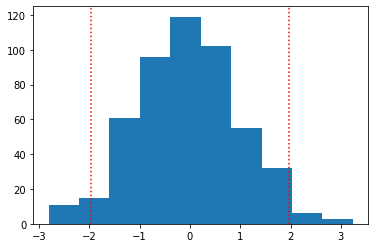

In [112]:
# I collected tstats across 500 replications and plot the histogram
plt.hist(ts)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [120]:
# I check that the distribution is outside of the 0.025 to 0.0975 quantiles of the normal with probability close to 0.05
(np.abs(ts)>1.96).mean()

0.048

### Question 3 Response: 
The probability to reject the null of effect is .05, much closer than our last procedure. By redrawing the application of the policy at each replication, we are more conifident in the effect of the policy because we leave less to chance that one of the 500 samples happens to fit the data well due to chance, so we reject the null of effect at a lower rate.

### Question 3 Solution - Code:

In [114]:
# Question 3 Solution : Redrawing policy at each replication
ts2 = []
coef = []

for i in tqdm(range(500)):
    fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
    data['fp'] = data['statefip'].map(fpol)
    data = data.assign(y2=np.random.normal(mean, np.sqrt(variance), 65685))
    results = smf.ols('y2 ~ fp', data=data).fit()
    ts2.append(results.tvalues[1])
    coef.append(results.params[1])

100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


In [124]:
(np.abs(ts2)>1.96).mean()

0.046

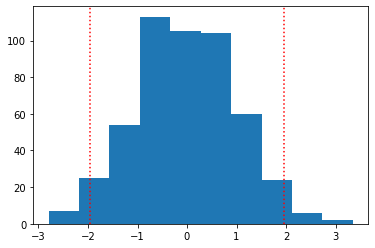

In [125]:
tstats = ts2
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

### Question 4 Solution:

In [126]:
ts3 = []
ts3_hetero = []

for i in tqdm(range(500)):
    temp = data.copy()
    results4 = smf.ols('lnwage ~ yrseduc + age + age2', data=temp).fit()
    residuals = results4.resid
    temp['residuals_sqr'] = np.square(residuals)
    s_sqr = smf.ols('residuals_sqr ~ yrseduc + age + age2', data=temp).fit()
   
    temp['y'] = np.sqrt(s_sqr.predict()) * np.random.normal(size=len(data))
    results = smf.ols('y ~ fp', data = temp).fit()
    results_hetero = smf.ols('y ~ fp', data = temp).fit(cov_type='HC0')
    
    ts3.append(results.tvalues[1])
    ts3_hetero.append(results_hetero.tvalues[1])

100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


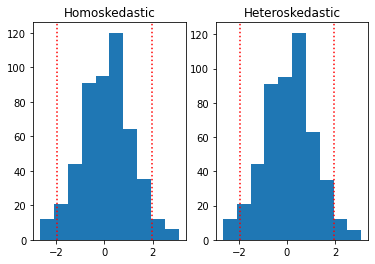

In [127]:
plt.subplot(1,2,1)
plt.hist(ts3)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Homoskedastic')

plt.subplot(1,2,2)
plt.hist(ts3_hetero)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Heteroskedastic')

plt.show()

### Question 5 Solution:

In [10]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data = data.assign(v=lambda x:(1-rho)*data['u'] + rho*np.random.normal(1))
data

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp,u,v
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True,0.906177,1.093420
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True,-0.371151,0.454756
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True,0.451419,0.866041
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True,-0.268230,0.506217
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True,-0.494404,0.393129
...,...,...,...,...,...,...,...,...,...,...,...,...
65680,2012,Hawaii,282.87,24,Male,16.0,28.899000,3.363807,576.0,False,1.357061,1.318862
65681,2012,Hawaii,362.23,49,Male,18.0,18.525000,2.919121,2401.0,False,0.090927,0.685795
65682,2012,Hawaii,362.23,44,Female,20.0,18.525000,2.919121,1936.0,False,-0.036092,0.622285
65683,2012,Hawaii,282.87,28,Male,18.0,24.082500,3.181485,784.0,False,-0.609543,0.335560


### Question 6 Solution:

In [11]:
def pair_corr(data):
    p_1, p_2 = [], []
    
    for i in tqdm(range(500)):
        s_1 = data.sample(1)
        data = data.assign(p_state=s_1['statefip'].values[0])
        s_2 = data.query('statefip == p_state').sample(1)
        p_1.append(s_1['u'].values[0])
        p_2.append(s_2['u'].values[0])

    return np.corrcoef(p_1, p_2)[0][1]

In [12]:
def corr_placebo(data):
    p_1, p_2 = [], []
    p = np.random.random_integers(0, 65685, size=(500, 2))
    for i, j in p:
        p_1.append(data.iloc[[i]]['u'].values[0])
        p_2.append(data.iloc[[j]]['u'].values[0])

    return np.corrcoef(p_1, p_2)[0][1]


In [13]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(pair_corr(data))
print(corr_placebo(data))

rho=0.8
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(pair_corr(data))
print(corr_placebo(data))

100%|██████████| 500/500 [00:04<00:00, 123.17it/s]
<ipython-input-12-90761c0f8cd2>:3: DeprecationWarning: This function is deprecated. Please call randint(0, 65685 + 1) instead
  p = np.random.random_integers(0, 65685, size=(500, 2))


0.04832685125180202


  3%|▎         | 13/500 [00:00<00:04, 120.90it/s]

0.009941596429640908


100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


-0.004733936196594542
-0.009507688417019301


### Question 7 Solution:

In [14]:
def reg_cluster(data): # here is an example of clustered errors 
    rhos= [0.2, 0.5, 0.8]
    res = []
    for i in tqdm(rhos):
        ts = []
        for j in tqdm(range(500)):
            data['u'] = np.random.normal(size=len(data))
            data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-i)*x.to_numpy() + i*np.random.normal(size=1))
            data['y'] =  data.v
            results = smf.ols('y ~ fp', data=data).fit(cov_type='cluster',cov_kwds={"groups":data['statefip']}) 
            ts.append(results.tvalues[1])
        res.append(['cluster', i, (np.abs(ts)>1.96).mean()])
    return res

In [15]:
# and here the regression without clustered standard errors
def reg_fit(data):
    rhos= [0.2, 0.5, 0.8]
    res = []
    for i in rhos:
        ts = []
        for j in tqdm(range(500)):
            data['u'] = np.random.normal(size=len(data))
            data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-i)*x.to_numpy() + i*np.random.normal(size=1))
            data['y'] =  data.v
            results = smf.ols('y ~ fp', data=data).fit()
            ts.append(results.tvalues[1])
        res.append(['fit', i, (np.abs(ts)>1.96).mean()])
    return res

In [16]:
# and here the regression without clustered standard errors
def reg_hetero(data):
    rhos= [0.2, 0.5, 0.8]
    res = []
    for i in rhos:
        ts = []
        for j in tqdm(range(500)):
            data['u'] = np.random.normal(size=len(data))
            data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-i)*x.to_numpy() + i*np.random.normal(size=1))
            data['y'] =  data.v
            results = smf.ols('y ~ fp', data = data).fit(cov_type='HC0')
            ts.append(results.tvalues[1])
        res.append(['hetero', i, (np.abs(ts)>1.96).mean()])
    return res

In [23]:
reg_hetero(data)

100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


[['hetero', 0.2, 0.846], ['hetero', 0.5, 0.94], ['hetero', 0.8, 0.958]]

In [24]:
reg_fit(data)

100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


[['fit', 0.2, 0.848], ['fit', 0.5, 0.942], ['fit', 0.8, 0.97]]

In [25]:
reg_cluster(data)

 31%|███       | 155/500 [00:45<01:40,  3.43it/s]


 62%|██████▏   | 309/500 [01:36<00:55,  3.46it/s]


 93%|█████████▎| 463/500 [02:20<00:10,  3.55it/s]


 23%|██▎       | 117/500 [00:32<01:47,  3.57it/s]


 54%|█████▍    | 271/500 [01:16<01:04,  3.57it/s]


 85%|████████▌ | 425/500 [02:01<00:22,  3.29it/s]


 16%|█▌        | 79/500 [00:23<02:07,  3.31it/s]


 47%|████▋     | 233/500 [01:12<01:15,  3.52it/s]


 77%|███████▋  | 387/500 [01:56<00:32,  3.52it/s]


100%|██████████| 3/3 [07:22<00:00, 147.59s/it]


[['cluster', 0.2, 0.058], ['cluster', 0.5, 0.058], ['cluster', 0.8, 0.074]]